<a href="https://colab.research.google.com/github/Marshanduh/Drowsiness-Classification/blob/main/ALP_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Eksperimen Penggunaan YOLOv8 untuk Klasifikasi Kantuk Pengemudi Berdasarkan Citra Mata dalam Kondisi Pencahayaan Rendah

Oleh Marshanda [0706012210056]

##Pendahuluan

Notebook ini melakukan eksperimen klasifikasi kantuk pengemudi berdasarkan kondisi mata (terbuka / tertutup) menggunakan YOLOv8, dengan simulasi citra low-light (pencahayaan rendah). Eksperimen dilakukan untuk menilai robust-ness model terhadap degradasi brightness.

#### 🧪 Experimental Setup

- Preprocessing:
  - Normalize and resize all images to `128x128`.
  - Brightness reduction for low-light simulation.
  
- Training:
  - Train YOLOv8 classifier with balanced dataset.
  
- Evaluation:
  - Compare model performance on normal vs. low-light test images.

---

##Set-Up dan Instalasi

In [11]:
# Install Ultralytics YOLOv8
!pip install ultralytics


##Import Libraries

In [12]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix


##Load Dataset

###Dataset Description

#### 🚗 Drowsiness Detection using Eye State Images
Link to dataset: https://www.kaggle.com/datasets/dhirdevansh/eye-dataset-openclose-for-drowsiness-prediction/data  
#### 📚 Dataset Overview

This dataset is meticulously curated for the development of AI-driven drowsiness detection systems. It contains grayscale images of a **single eye**, classified into two categories:

- **Open**
- **Closed**

These are ideal for training lightweight classification models to detect early signs of driver fatigue in real-time systems.

---

#### 📂 Dataset Details

| Feature            | Description                     |
|--------------------|----------------------------------|
| Classes            | `Open`, `Closed`                |
| Image Size         | 93 x 93 pixels                  |
| DPI                | 96                              |
| Color Depth        | 8-bit Grayscale                 |
| Format             | Lightweight (ideal for edge AI) |

---

#### 🎯 Purpose & Application

- **Real-Time Drowsiness Detection**  
  Enhance vehicle safety by integrating AI that monitors driver’s eye states.
  
- **Edge AI Research**  
  Perfect for deploying on embedded devices like **Jetson Nano** or **Raspberry Pi**.
  
- **Academic Use**  
  Suitable for students, researchers, and developers exploring fatigue detection or small-scale image classification.

---

Let’s begin with **data preparation and preprocessing** ⬇️


#### 📌 Annotation & Dataset Preparation

To adapt the dataset for YOLO-based training, all images were annotated using **Roboflow**, a web-based platform for dataset management and labeling. Each eye image (classified as "open" or "closed") was labeled accordingly, and the dataset was exported in **YOLO format**, ensuring compatibility with **YOLOv8** classification or object detection models.

The dataset was then split into:
- `train/` (for model training) **82%**
- `valid/` (for validation during training) **12%**
- `test/` (for final evaluation) **6%**

All folders follow the required structure for Ultralytics YOLOv8.


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

dataset_path = '/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder'

for root, dirs, files in os.walk(dataset_path):
    print(f"📁 {root}")
    for file in files[:5]:
        print(f" └── {file}")
    print()


📁 /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder
 └── README.roboflow.txt
 └── README.dataset.txt
 └── .DS_Store

📁 /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train
 └── .DS_Store

📁 /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train/Closed_Eyes
 └── s0014_00083_0_0_0_0_0_01_png.rf.b59d3faa3b3bfe7f2c0dbc1a9bee71b1.jpg
 └── s0016_01059_1_0_0_0_1_01_png.rf.529cf4f69468f6aa35849b0b12ea0664.jpg
 └── s0016_01716_1_0_0_0_1_01_png.rf.8286b4f0d87597c9f70f0bd778af69c3.jpg
 └── s0001_01549_0_1_0_0_0_01_png.rf.7e274157127fb89106a3ba00ed966f76.jpg
 └── s0016_00620_1_0_0_0_1_01_png.rf.a4affb423ea205332b60812b5e8c1827.jpg

📁 /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train/Open_Eyes
 └── s0012_08375_0_0_1_1_0_02_png.rf.11cb0504fac04d165226d89a403fc417.jpg
 └── s0036_02609_1_0_1_0_0_01_png.rf.57d3ae0a4500b79fc844dc1587300dc2.jpg
 └── s0036_03380

📊 Tabel Distribusi Data:


,Open_Eyes,Closed_Eyes,Total
train,2794,2794,5588
valid,392,392,784
test,195,195,390
Total,3381,3381,6762


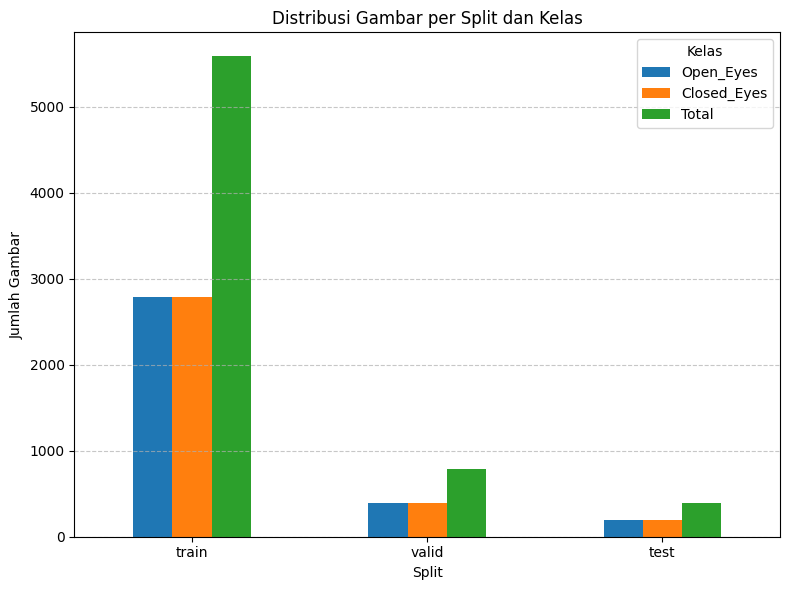

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

base_path = "/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder"
splits = ['train', 'valid', 'test']
classes = ['Open_Eyes', 'Closed_Eyes']

# Hitung jumlah file per kelas per split
data_distribution = defaultdict(dict)
for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))])
        data_distribution[split][cls] = count

df = pd.DataFrame(data_distribution).T
df["Total"] = df.sum(axis=1)
df.loc["Total"] = df.sum()

# grafik
print("📊 Tabel Distribusi Data:")
display(df)

ax = df.drop("Total").plot(kind="bar", figsize=(8,6))
plt.title("Distribusi Gambar per Split dan Kelas")
plt.xlabel("Split")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Kelas")
plt.tight_layout()
plt.show()

In [16]:
import os
import random

# Path dataset asli
base_path = "/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder"
splits = ['train', 'valid', 'test']
classes = ['Open_Eyes', 'Closed_Eyes']

for split in splits:
    class_files = {}

    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        files = sorted([f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))])
        class_files[cls] = files

    # Hitung jumlah minimum dari kedua kelas
    min_count = min(len(class_files['Open_Eyes']), len(class_files['Closed_Eyes']))

    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        files = class_files[cls]

        # Jika kelebihan, hapus random file
        if len(files) > min_count:
            to_delete = random.sample(files, len(files) - min_count)
            for fname in to_delete:
                os.remove(os.path.join(folder, fname))
            print(f"🗑️ Deleted {len(to_delete)} images from {split}/{cls}")
        else:
            print(f"✅ {split}/{cls} already balanced")

print("🎯 Dataset berhasil diseimbangkan langsung di folder asli.")


✅ train/Open_Eyes already balanced
✅ train/Closed_Eyes already balanced
✅ valid/Open_Eyes already balanced
✅ valid/Closed_Eyes already balanced
✅ test/Open_Eyes already balanced
✅ test/Closed_Eyes already balanced
🎯 Dataset berhasil diseimbangkan langsung di folder asli.


📊 Tabel Distribusi Data Setelah Diseimbangkan:


,Open_Eyes,Closed_Eyes,Total
train,2794,2794,5588
valid,392,392,784
test,195,195,390
Total,3381,3381,6762


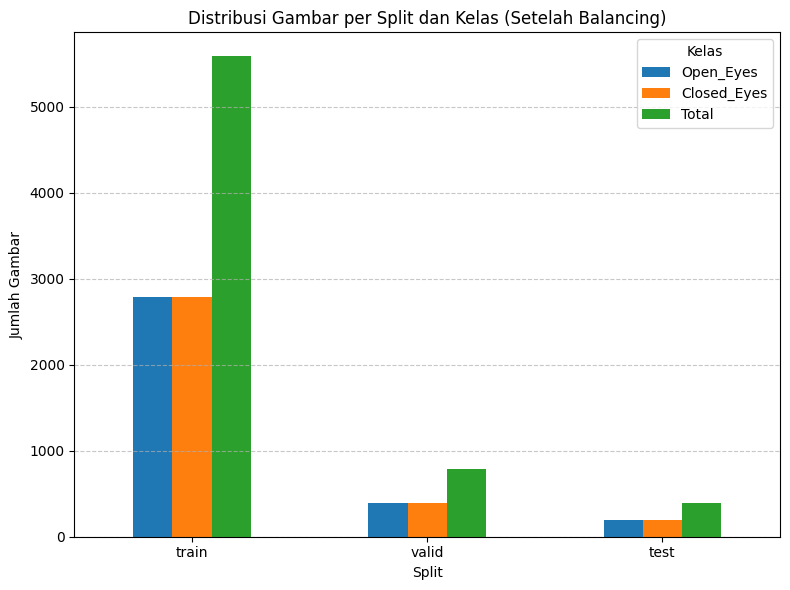

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Path dataset yang sudah diseimbangkan (sama seperti sebelumnya)
base_path = "/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder"
splits = ['train', 'valid', 'test']
classes = ['Open_Eyes', 'Closed_Eyes']

# Hitung ulang jumlah file per kelas per split setelah balancing
balanced_distribution = defaultdict(dict)
for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))])
        balanced_distribution[split][cls] = count

df_balanced = pd.DataFrame(balanced_distribution).T
df_balanced["Total"] = df_balanced.sum(axis=1)
df_balanced.loc["Total"] = df_balanced.sum()

print("📊 Tabel Distribusi Data Setelah Diseimbangkan:")
display(df_balanced)

ax = df_balanced.drop("Total").plot(kind="bar", figsize=(8,6))
plt.title("Distribusi Gambar per Split dan Kelas (Setelah Balancing)")
plt.xlabel("Split")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Kelas")
plt.tight_layout()
plt.show()


##Preprocessing Dataset: Simulasi Low-Light

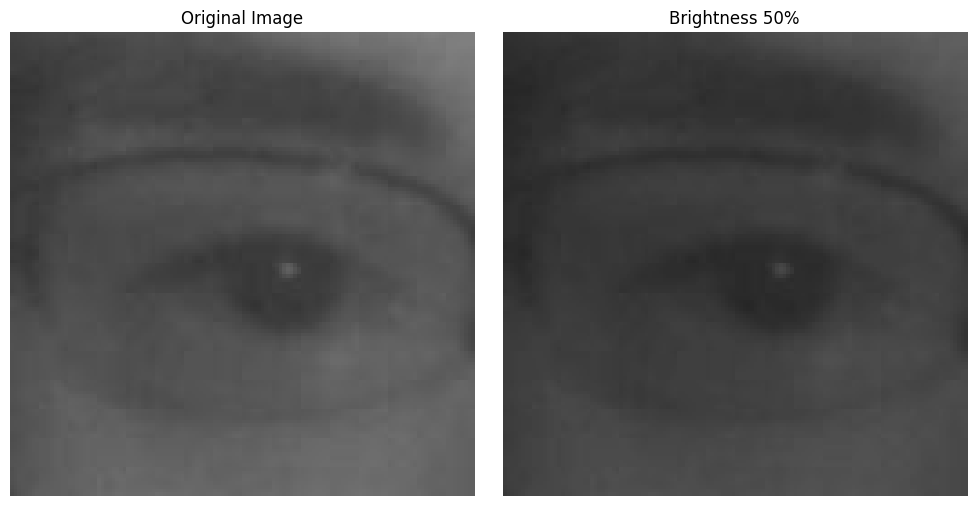

In [18]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

def load_image_with_brightness_50(path):
    img = Image.open(path)
    enhancer = ImageEnhance.Brightness(img)
    img_bright = enhancer.enhance(0.75)  # 50% brightness
    return img_bright

sample_img_path = "/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train/Open_Eyes/s0001_02599_0_1_1_0_0_01_png.rf.df592a5ac2cd0f134c5e4a6cb77e8cf9.jpg"

# Load gambar original dan brightness 50%
img_original = Image.open(sample_img_path)
img_50 = load_image_with_brightness_50(sample_img_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_original)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img_50)
axes[1].set_title("Brightness 50%")
axes[1].axis('off')

plt.tight_layout()
plt.show()


##Model Training

### 🛠️ YOLOv8 Classification Model

We will use **YOLOv8 (Ultralytics)** for **image classification** to distinguish between open and closed eyes:

- **Why YOLOv8?**
  - Modern architecture with excellent speed and accuracy.
  - Supports classification via `yolo task=classify`.
  - Easy to integrate into real-time systems.

---



###Training for Original Image

In [23]:
import os

dataset_path = "/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder"

# Remove all .DS_Store files recursively
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file == '.DS_Store':
            os.remove(os.path.join(root, file))
            print(f"Removed: {os.path.join(root, file)}")

Removed: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/.DS_Store
Removed: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train/.DS_Store
Removed: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/valid/.DS_Store
Removed: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/test/.DS_Store


In [24]:
def check_directory_structure(base_path):
    required = ['train', 'valid']
    classes = ['Open_Eyes', 'Closed_Eyes']

    for split in required:
        path = os.path.join(base_path, split)
        if not os.path.exists(path):
            print(f"❌ Missing directory: {path}")
            continue

        print(f"\n✅ {split} directory exists")
        for cls in classes:
            cls_path = os.path.join(path, cls)
            if os.path.exists(cls_path):
                count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                print(f"  {cls}: {count} images")
            else:
                print(f"  ❌ Missing class directory: {cls}")

check_directory_structure(dataset_path)


✅ train directory exists
  Open_Eyes: 2794 images
  Closed_Eyes: 2794 images

✅ valid directory exists
  Open_Eyes: 392 images
  Closed_Eyes: 392 images



🔍 train directory contents:
  Open_Eyes: 2794 images
    Sample: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train/Open_Eyes/s0012_08375_0_0_1_1_0_02_png.rf.11cb0504fac04d165226d89a403fc417.jpg


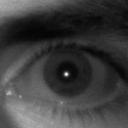

  Closed_Eyes: 2794 images
    Sample: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train/Closed_Eyes/s0014_00083_0_0_0_0_0_01_png.rf.b59d3faa3b3bfe7f2c0dbc1a9bee71b1.jpg


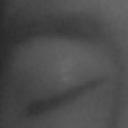


🔍 valid directory contents:
  Open_Eyes: 392 images
    Sample: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/valid/Open_Eyes/s0014_07660_0_0_1_1_1_02_png.rf.9e6620a65e53841d28beaeb1bbf52893.jpg


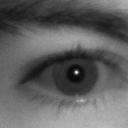

  Closed_Eyes: 392 images
    Sample: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/valid/Closed_Eyes/s0014_00030_0_0_0_0_0_01_png.rf.c9e4ecff452866131bd80a318ec97fb5.jpg


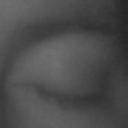

In [27]:
import os
from IPython.display import display, Image

# Clean dataset path
dataset_path = "/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder"

# 1. Remove all hidden files
!find "{dataset_path}" -type f \( -name '.DS_Store' -o -name '._*' \) -delete

# 2. Verify directory structure
def verify_structure():
    splits = ['train', 'valid']
    classes = ['Open_Eyes', 'Closed_Eyes']

    for split in splits:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"❌ Missing directory: {split_path}")
            continue

        print(f"\n🔍 {split} directory contents:")
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            if os.path.exists(cls_path):
                images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                print(f"  {cls}: {len(images)} images")
                if images:
                    # Display sample image
                    sample = os.path.join(cls_path, images[0])
                    print(f"    Sample: {sample}")
                    try:
                        display(Image(filename=sample))
                    except:
                        print("    ⚠️ Could not display image - may be corrupt")
            else:
                print(f"  ❌ Missing class directory: {cls}")

verify_structure()

In [28]:
import yaml

yaml_content = f"""
# YOLOv8 Classification Dataset Config
path: {dataset_path}  # absolute path to dataset root
train: train  # relative to 'path'
val: valid    # relative to 'path'

# Class names mapping
names:
  0: Open_Eyes
  1: Closed_Eyes
"""

data_yaml_path = "/content/drive/MyDrive/CompVis/ALP/yolov8_classification_data.yaml"
with open(data_yaml_path, 'w') as f:
    f.write(yaml_content)

print("✅ YAML file created successfully!")
print("\nFile content:")
print(yaml_content)

# Verify YAML file was written correctly
assert os.path.exists(data_yaml_path), "YAML file was not created!"


✅ YAML file created successfully!

File content:

# YOLOv8 Classification Dataset Config
path: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder  # absolute path to dataset root
train: train  # relative to 'path'
val: valid    # relative to 'path'

# Class names mapping
names:
  0: Open_Eyes
  1: Closed_Eyes



Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/yolov8_classification_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=openclosed_eyes_cls, nbs=64, nms=False, opset=None, optimize=Fa

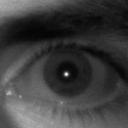

Successfully loaded: /content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/train/Open_Eyes/s0012_08375_0_0_1_1_0_02_png.rf.11cb0504fac04d165226d89a403fc417.jpg


In [32]:
from ultralytics import YOLO
import shutil

# Clean previous runs
shutil.rmtree('runs/classify/openclosed_eyes_cls', ignore_errors=True)

# Initialize model
model = YOLO('yolov8n-cls.pt')

# Training with verification
try:
    results = model.train(
        data='/content/drive/MyDrive/CompVis/ALP/dataset1/OpenClosedEyesClassification.v1i.folder/yolov8_classification_data.yaml',
        epochs=25,
        batch=16,
        imgsz=128,
        name='openclosed_eyes_cls',
        exist_ok=True,
        verbose=True
    )
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("\n🚨 Critical Debugging Steps:")

    # 1. Verify dataset access
    print("\n1. Dataset access verification:")
    !ls -la "{dataset_path}"

    # 2. Check YAML file contents
    print("\n2. YAML file contents:")
    !cat "{data_yaml_path}"

    # 3. Test image loading
    print("\n3. Testing image loading:")
    test_img = os.path.join(dataset_path, "train/Open_Eyes")
    if os.path.exists(test_img):
        test_img = os.path.join(test_img, os.listdir(test_img)[0])
        try:
            display(Image(filename=test_img))
            print(f"Successfully loaded: {test_img}")
        except:
            print(f"Failed to load: {test_img}")
